# Projeto Marinha do Brasil

## Laboratório de Processamento de Sinais - UFRJ

### Autor: Vinícius dos Santos Mello <viniciusdsmello@poli.ufrj.br>

In [11]:
import os
import sys
import time
sys.path.insert(0,'..')

from noveltyDetectionConfig import CONFIG
import numpy as np
import itertools
import multiprocessing
from datetime import datetime, timedelta

from Functions.email_utils import EmailConnection, Email
from NNNoveltyDetectionAnalysis import NNNoveltyDetectionAnalysis

num_processes = multiprocessing.cpu_count()

# Enviroment variables
data_path = CONFIG['OUTPUTDATAPATH']
results_path = CONFIG['PACKAGE_NAME']

training_params = {
    "Technique": "NeuralNetwork",
    "DevelopmentMode": False,
    "DevelopmentEvents": 400,
    "NoveltyDetection": True,
    "InputDataConfig": {
        "database": "4classes",
        "n_pts_fft": 1024,
        "decimation_rate": 3,
        "spectrum_bins_left": 400,
        "n_windows": 1,
        "balance_data": False
    },
    "OptmizerAlgorithm": {
        "name": "Adam",
        "parameters": {
            "learning_rate": 0.001,
            "beta_1": 0.90,
            "beta_2": 0.999,
            "epsilon": 1e-08,
            "learning_decay": 1e-6,
            "momentum": 0.3,
            "nesterov": True
        }
    },
    "HyperParameters": {
        "n_folds": 4,
        "n_epochs": 300,
        "n_inits": 2,
        "batch_size": 256,
        "kernel_initializer": "uniform",
        "hidden_activation_function": "tanh", #"relu",
        "classifier_output_activation_function": "softmax",
        "norm": "mapstd",
        "metrics": ["accuracy"],
        "loss": "mean_squared_error",
        "dropout": False,
        "dropout_parameter": 0.0,
        "regularization": None,
        "regularization_parameter": 0.0
    },
    "callbacks": {
        "EarlyStopping": {
            "patience": 30,
            "monitor": "val_loss"
        }
    }
}
analysis = NNNoveltyDetectionAnalysis(parameters=training_params, model_hash="", load_hash=False, load_data=True, verbose=True)
all_data, all_trgt, all_trgt_sparse = analysis.getData()

trn_data = analysis.trn_data
trn_trgt = analysis.trn_trgt
trn_trgt_sparse = analysis.trn_trgt_sparse

models = analysis.models

[+] Time to read data file: 1.52878093719 seconds
Qtd event of A is 12939
Qtd event of B is 29352
Qtd event of C is 11510
Qtd event of D is 23760

Biggest class is B with 29352 events
Total of events in the dataset is 77561
Reading from /home/vinicius.mello/Workspace/SonarAnalysis_2/Results/NoveltyDetection/4_folds_cross_validation.jbl


#### Perform the training of the model

In [20]:
trn_data = analysis.trn_data
trn_trgt = analysis.trn_trgt
trn_trgt_sparse = analysis.trn_trgt_sparse

for inovelty in range(len(analysis.class_labels)):
    startTime = time.time()
    
    analysis.train(layer=1,
                   inovelty=inovelty,
                   trainingType="neuronSweep", #foldSweep, neuronSweep, normal
                   hidden_neurons=[50],
                   neurons_variation_step=5,
                   numThreads=10,
                   model_hash=analysis.model_hash)
    
    duration = str(timedelta(seconds=float(time.time() - startTime)))
    
    name = "Vinícius Mello"
    email = "viniciusdsmello@gmail.com"
    password = "duqmnajvpwrdnvvv"
    mail_server = "smtp.gmail.com"
    
    to_email = "viniciusdsmello@lps.ufrj.br"
    to_name = "Vinícius Mello"
    
    subject = '[Projeto Sonar] - Treinamento de modelo concluído'
    message = "Technique: Neural Network\n"
    message = message + "Training Type: Neurons Sweep\n"
    message = message + "Novelty Class: {}".format(analysis.class_labels[inovelty])
    message = message + "Duration {}\n".format(duration)
    attachments = []
    server = EmailConnection(mail_server, email, password)
    email = Email(from_='"%s" <%s>' % (name, email), #you can pass only email
                  to='"%s" <%s>' % (to_name, to_email), #you can pass only email
                  subject=subject, message=message, attachments=attachments)
    server.send(email)
    server.close()
    
    print "The training of the model for novelty class {0} took {1} to be performed\n".format(analysis.class_labels[inovelty], duration)

python neuralnetwork_train.py --layer 1 --novelty 0 --threads 10 --type neuronSweep --hiddenNeurons 50 --neuronsVariationStep 5 --modelhash 0060d0ad28e73067a8cebc2525509ea110a353950eb281ca129b7901866b94ea
The training of the model for novelty class A took 0:10:45.707192 to be performed

python neuralnetwork_train.py --layer 1 --novelty 1 --threads 10 --type neuronSweep --hiddenNeurons 50 --neuronsVariationStep 5 --modelhash 0060d0ad28e73067a8cebc2525509ea110a353950eb281ca129b7901866b94ea
The training of the model for novelty class B took 0:06:57.418957 to be performed

python neuralnetwork_train.py --layer 1 --novelty 2 --threads 10 --type neuronSweep --hiddenNeurons 50 --neuronsVariationStep 5 --modelhash 0060d0ad28e73067a8cebc2525509ea110a353950eb281ca129b7901866b94ea
The training of the model for novelty class C took 0:09:59.780302 to be performed

python neuralnetwork_train.py --layer 1 --novelty 3 --threads 10 --type neuronSweep --hiddenNeurons 50 --neuronsVariationStep 5 --modelh

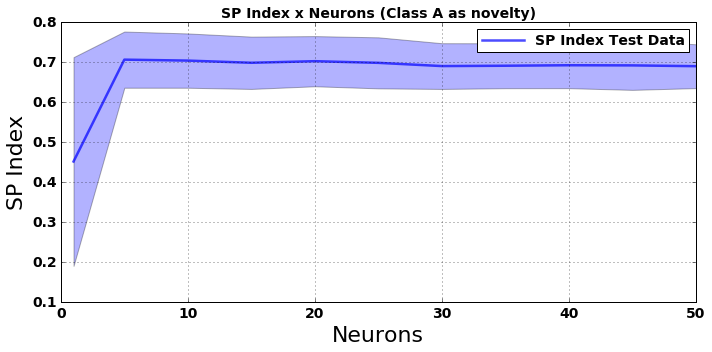

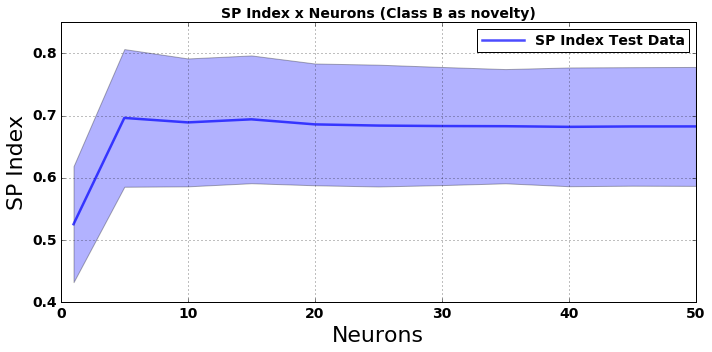

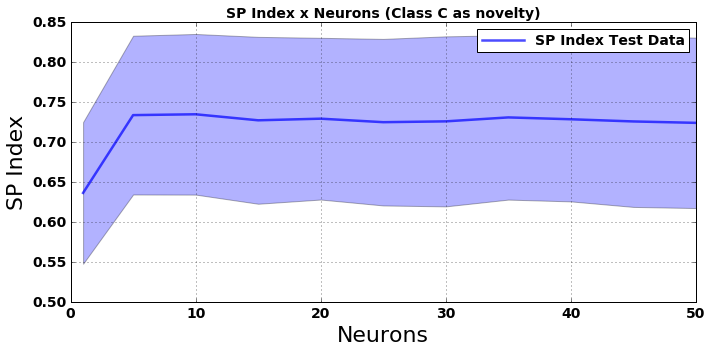

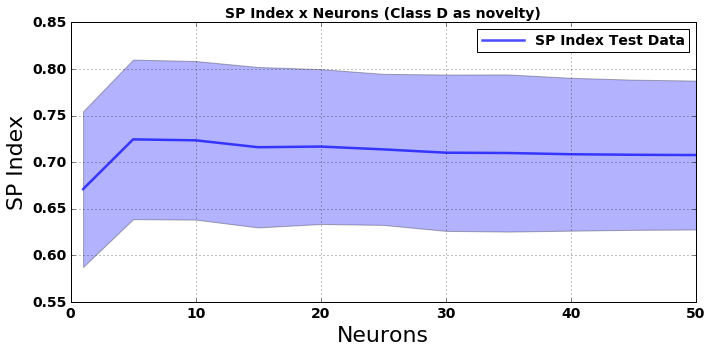

In [4]:
%matplotlib inline 

from sklearn import metrics
from sklearn import preprocessing
from sklearn.externals import joblib
from Functions.StatisticalAnalysis import KLDiv, EstPDF
import matplotlib.pyplot as plt

# Choose layer 
layer = 1

# Choose neurons topology
hidden_neurons = [50]

step = 5
neurons_mat = [1] + range(step,hidden_neurons[layer-1]+step,step)
neurons_mat = neurons_mat[:len(neurons_mat)-layer+2]

analysis_name = 'sp_index_%i_layer_keras_class_weights_v2'%(layer)
analysis_file = os.path.join(analysis.getBaseResultsPath(), "AnalysisFiles", analysis_name + ".jbl")    

verbose = True

# Plot parameters
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.fontsize'] = 14
m_colors = ['b', 'r', 'g', 'y']
figsize = (10,5)


results = {}
spIndex = np.zeros([len(analysis.class_labels), analysis.parameters["HyperParameters"]["n_folds"], len(neurons_mat)])

if not os.path.exists(analysis_file):
    for inovelty in range(len(analysis.class_labels)):
        folds = range(len(analysis.CVO[inovelty]))
        for ifold in folds:    
            class_eff_mat = np.zeros([analysis.parameters["HyperParameters"]["n_folds"],len(np.unique(all_trgt))])
            known_sp_mat = np.zeros([analysis.parameters["HyperParameters"]["n_folds"]])

            buff = np.zeros([len(np.unique(all_trgt))-1])
            class_eff = np.zeros([len(np.unique(all_trgt))], dtype=object)
            known_sp = np.zeros([len(np.unique(all_trgt))], dtype=object)

            def getSP(ineuron):
                train_id, test_id = analysis.CVO[inovelty][ifold]

                # normalize known classes
                if analysis.parameters["HyperParameters"]["norm"] == "mapstd":
                    scaler = preprocessing.StandardScaler().fit(all_data[all_trgt!=inovelty][train_id,:])
                elif analysis.parameters["HyperParameters"]["norm"] == "mapstd_rob":
                    scaler = preprocessing.RobustScaler().fit(all_data[all_trgt!=inovelty][train_id,:])
                elif analysis.parameters["HyperParameters"]["norm"] == "mapminmax":
                    scaler = preprocessing.MinMaxScaler().fit(all_data[all_trgt!=inovelty][train_id,:])

                known_data = scaler.transform(analysis.trn_data[inovelty][test_id,:])
                known_trgt = analysis.trn_trgt[inovelty][test_id]
                classifier = models[inovelty].get_model(data  = analysis.trn_data[inovelty],
                                                        trgt  = analysis.trn_trgt[inovelty], 
                                                        hidden_neurons = hidden_neurons[:layer-1]+[ineuron],
                                                        layer = layer,
                                                        ifold = ifold
                                                       )

                output = classifier.predict(known_data)

                num_known_classes = analysis.trn_trgt_sparse[inovelty].shape[1]
                thr_value = 0.2
                for iclass, class_id in enumerate(np.unique(all_trgt)):
                    if iclass == inovelty:
                        continue
                    output_of_class_events = output[known_trgt==iclass-(iclass>inovelty),:]
                    correct_class_output = np.argmax(output_of_class_events,axis=1)==iclass-(iclass>inovelty)
                    output_above_thr = output_of_class_events[correct_class_output,iclass-(iclass>inovelty)]>thr_value
                    class_eff = float(sum(output_above_thr))/float(len(output_of_class_events))
                    buff[iclass-(iclass>inovelty)] = class_eff

                sp_index = (np.sqrt(np.mean(buff,axis=0)*np.power(np.prod(buff),1./float(len(buff)))))
                
                return ineuron, sp_index

            # Start Parallel processing
            p = multiprocessing.Pool(processes=num_processes)

            if verbose:
                print '[*] Calculating SP Index ...'
            results = p.map(getSP, neurons_mat)

            for ineuron_index in range(len(neurons_mat)):
                spIndex[inovelty, ifold, neurons_mat.index(results[ineuron_index][0])] = results[ineuron_index][1]

            p.close()
            p.join()

    joblib.dump([neurons_mat,spIndex],analysis_file,compress=9)
else:
    [neurons_mat, spIndex] = joblib.load(analysis_file)

    
for inovelty in range(len(analysis.class_labels)):
    # Plot results    
    fig = plt.subplots(figsize=figsize)
    ax = plt.subplot(1,1,1)
    
    mean_sp = np.mean(spIndex[inovelty,:], axis=0)
    error_sp = np.std(spIndex[inovelty,:,:], axis=0)
    
    ax.plot(neurons_mat, mean_sp, color='b', alpha=0.7, linewidth=2.5, label='SP Index Test Data')
    
    ax.fill_between(neurons_mat, mean_sp+error_sp, mean_sp-error_sp, facecolor='blue', alpha=0.3)
    
    ax.set_title('SP Index x Neurons (Class {} as novelty)'.format(analysis.class_labels[inovelty]),
                                  fontsize=14, fontweight='bold')
    ax.set_ylabel('SP Index', fontsize=22)
    ax.set_xlabel('Neurons', fontsize=22)
    ax.grid()
    ax.legend()
    plt.tight_layout()
plt.show()

In [12]:
from sklearn import preprocessing

inovelty = 3
iclass = 2
ifold = 2

train_id, test_id = analysis.CVO[inovelty][ifold]

# normalize known classes
if analysis.parameters["HyperParameters"]["norm"] == "mapstd":
    scaler = preprocessing.StandardScaler().fit(analysis.trn_data[inovelty][train_id,:])
elif analysis.parameters["HyperParameters"]["norm"] == "mapstd_rob":
    scaler = preprocessing.RobustScaler().fit(analysis.trn_data[inovelty][train_id,:])
elif analysis.parameters["HyperParameters"]["norm"] == "mapminmax":
    scaler = preprocessing.MinMaxScaler().fit(analysis.trn_data[inovelty][train_id,:])

known_data = scaler.transform(analysis.trn_data[inovelty][test_id,:])
known_trgt = analysis.trn_trgt[inovelty][test_id]

print np.unique(known_trgt)

[0. 1. 2.]


### Figures-of-Merit Analysis for a threshold variation at output layer

Novelty class: 0 - Topology: 400x5x3 - fold 0
Novelty class: 0 - Topology: 400x5x3 - fold 1
Novelty class: 0 - Topology: 400x5x3 - fold 2
Novelty class: 0 - Topology: 400x5x3 - fold 3
Novelty class: 1 - Topology: 400x5x3 - fold 0
Novelty class: 1 - Topology: 400x5x3 - fold 1
Novelty class: 1 - Topology: 400x5x3 - fold 2
Novelty class: 1 - Topology: 400x5x3 - fold 3
Novelty class: 2 - Topology: 400x5x3 - fold 0
Novelty class: 2 - Topology: 400x5x3 - fold 1
Novelty class: 2 - Topology: 400x5x3 - fold 2
Novelty class: 2 - Topology: 400x5x3 - fold 3
Novelty class: 3 - Topology: 400x5x3 - fold 0
Novelty class: 3 - Topology: 400x5x3 - fold 1
Novelty class: 3 - Topology: 400x5x3 - fold 2
Novelty class: 3 - Topology: 400x5x3 - fold 3


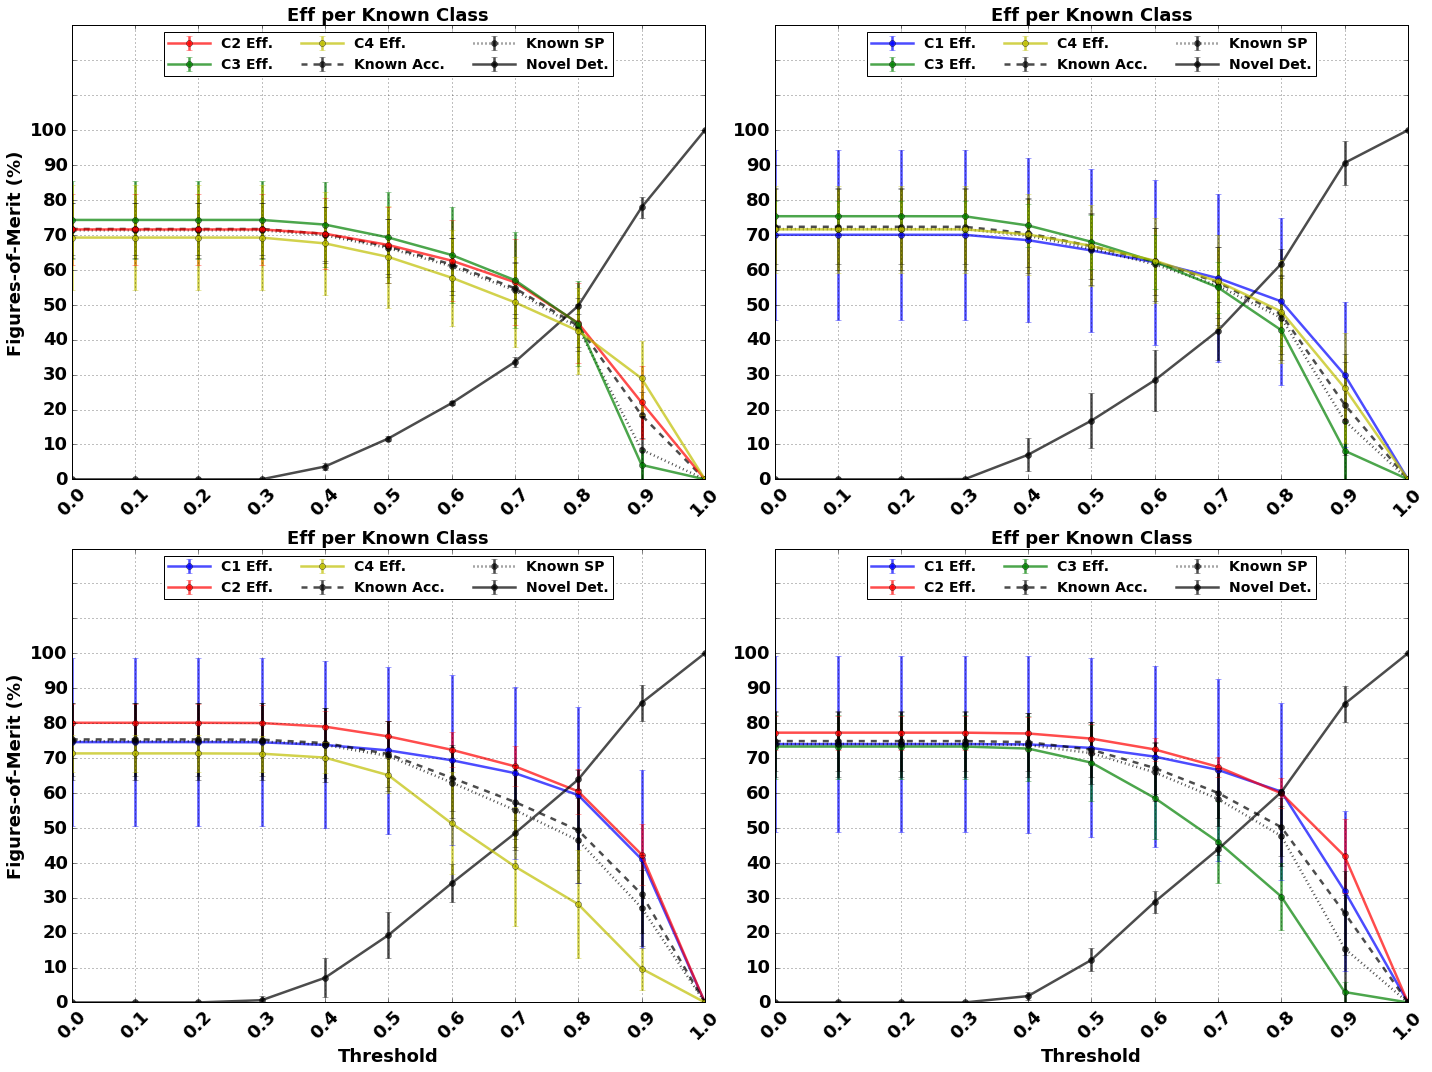

In [4]:
# Thresolds variation x Figures of Merit
%matplotlib inline 

from sklearn import metrics
from sklearn import preprocessing
from sklearn.externals import joblib
from Functions.StatisticalAnalysis import KLDiv, EstPDF
from Functions import FunctionsDataVisualization
import matplotlib.pyplot as plt

# Choose layer 
layer = 1

# Choose neurons topology
hidden_neurons = [5]

analysis_name = 'figures_of_merit_%i_layer_keras_class_weights'%(layer)
analysis_file = os.path.join(analysis.getBaseResultsPath(), "AnalysisFiles", analysis_name + ".jbl")    

verbose = True

# Plot parameters
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.fontsize'] = 14
m_colors = ['b', 'r', 'g', 'y']
figsize = (20,15)


if not os.path.exists(analysis_file):
    thr_mat = np.round(np.arange(0.0,1.1,0.1),3)
    thr_mat[thr_mat>-0.1] = abs(thr_mat[thr_mat>-0.1])
    n_folds = analysis.parameters["HyperParameters"]["n_folds"]
    class_eff_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(np.unique(all_trgt)),len(thr_mat)])
    novelty_eff_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(thr_mat)])
    known_acc_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(thr_mat)])
    known_sp_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(thr_mat)])
    known_trig_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(thr_mat)])
    
    for inovelty, novelty_class in enumerate(np.unique(analysis.all_trgt)):
        for ifold in range(len(analysis.CVO[inovelty])):
            train_id, test_id = analysis.CVO[inovelty][ifold]
            
            print 'Novelty class: %01.0f - Topology: %s - fold %i'%(novelty_class,
                                                                    models[inovelty].get_neurons_str(data=trn_data[inovelty], hidden_neurons=hidden_neurons)+'x'+str(trn_trgt_sparse[inovelty].shape[1]),
                                                                    ifold)
            classifier = models[inovelty].get_model(data=analysis.trn_data[inovelty], trgt=analysis.trn_trgt[inovelty],
                                                    hidden_neurons=hidden_neurons, layer=layer, ifold=ifold)
            
            # normalize known classes
            if analysis.parameters["HyperParameters"]["norm"] == "mapstd":
                scaler = preprocessing.StandardScaler().fit(all_data[all_trgt!=inovelty][train_id,:])
            elif analysis.parameters["HyperParameters"]["norm"] == "mapstd_rob":
                scaler = preprocessing.RobustScaler().fit(all_data[all_trgt!=inovelty][train_id,:])
            elif analysis.parameters["HyperParameters"]["norm"] == "mapminmax":
                scaler = preprocessing.MinMaxScaler().fit(all_data[all_trgt!=inovelty][train_id,:])

            known_data = scaler.transform(analysis.trn_data[inovelty][test_id,:])
            known_trgt = analysis.trn_trgt[inovelty][test_id]
            
            novelty_data = scaler.transform(all_data[all_trgt==inovelty])
            
            output = classifier.predict(known_data)
            novelty_output = classifier.predict(novelty_data)
            
            for ithr,thr_value in enumerate(thr_mat): 
                buff = np.zeros([len(np.unique(all_trgt))-1])
                for iclass, class_id in enumerate(np.unique(all_trgt)):
                    if iclass == inovelty:
                        continue
                    output_of_class_events = output[known_trgt==iclass-(iclass>inovelty),:]
                    correct_class_output = np.argmax(output_of_class_events,axis=1)==iclass-(iclass>inovelty)
                    output_above_thr = output_of_class_events[correct_class_output,iclass-(iclass>inovelty)]>thr_value
                    class_eff_mat[ifold, inovelty, iclass, ithr] = float(sum(output_above_thr))/float(len(output_of_class_events))
                    buff[iclass-(iclass>inovelty)] = class_eff_mat[ifold, inovelty, iclass, ithr]
                novelty_eff_mat[ifold, inovelty, ithr] = float(sum(1-(novelty_output>thr_value).any(axis=1)))/float(len(novelty_output))
                known_acc_mat[ifold, inovelty, ithr] = np.mean(buff,axis=0)
                known_sp_mat[ifold, inovelty, ithr]= (np.sqrt(np.mean(buff,axis=0)
                                                              *np.power(np.prod(buff),1./float(len(buff)))))
                known_trig_mat[ifold, inovelty, ithr]=float(sum(np.max(output,axis=1)>thr_value))/float(len(output))
    joblib.dump([class_eff_mat, novelty_eff_mat, known_acc_mat, known_sp_mat, known_trig_mat, thr_mat],
                analysis_file,compress=9)
else:
    print 'file exists'
    [class_eff_mat, novelty_eff_mat, known_acc_mat, known_sp_mat, known_trig_mat, thr_mat] = joblib.load(analysis_file) 

# plot analysis
import matplotlib.pyplot as plt
%matplotlib inline  

fig = plt.subplots(figsize=figsize)

for inovelty, novelty_class in enumerate(np.unique(all_trgt)):
    ax = plt.subplot(2,2,inovelty+1)
    for iclass, m_class in enumerate(np.unique(all_trgt)):
        if novelty_class == m_class:
            #a = 0
            ax.errorbar(thr_mat,np.mean(novelty_eff_mat[:,int(novelty_class),:],axis=0),
                        np.std(novelty_eff_mat[:,int(novelty_class),:],axis=0),fmt='o-',
                        color='k',alpha=0.7,linewidth=2.5,
                        label='Novel Det.')
            ax.errorbar(thr_mat,np.mean(known_acc_mat[:,int(novelty_class),:],axis=0),
                        np.std(known_acc_mat[:,int(novelty_class),:],axis=0),fmt='o--',
                        color='k',alpha=0.7,linewidth=2.5,
                        label='Known Acc.')
            ax.errorbar(thr_mat,np.mean(known_sp_mat[:,int(novelty_class),:],axis=0),
                        np.std(known_sp_mat[:,int(novelty_class),:],axis=0),fmt='o:',
                        color='k',alpha=0.7,linewidth=2.5,
                        label='Known SP')
#             ax.errorbar(thr_mat,np.mean(known_trig_mat[:,int(novelty_class),:],axis=0),
#                         np.std(known_trig_mat[:,int(novelty_class),:],axis=0),fmt='o-.',
#                         color='k',alpha=0.7,linewidth=2.5,
#                         label='Known Trig.')
        else:
            ax.errorbar(thr_mat,np.mean(class_eff_mat[:,int(novelty_class),int(m_class),:],axis=0),
                        np.std(class_eff_mat[:,int(novelty_class),int(m_class),:],axis=0),fmt='o-',
                        color=m_colors[int(m_class)],alpha=0.7,linewidth=2.5,
                       label='C%i Eff.'%(int(m_class)+1))
    ax.set_xticks(thr_mat)
    ax.set_xticklabels(thr_mat,rotation=45, fontsize=18)
    ax.set_title('Eff per Known Class',fontsize=18,weight='bold')
    ax.set_xlim([np.min(thr_mat), np.max(thr_mat)])
    
    ax.set_ylim([0.0, 1.3])
    y_ticks = np.arange(0.0,1.3,0.1)
    ax.set_yticks(y_ticks)
    y_tick_labels = 100*y_ticks[y_ticks<=1.0]
    y_tick_labels = y_tick_labels.astype(int)
    ax.set_yticklabels(y_tick_labels,fontsize=18)
    
    ax.grid()
    
    if inovelty > 1:
        ax.set_xlabel('Threshold',fontsize=18,weight='bold')
    if inovelty == 0 or inovelty == 2:
        ax.set_ylabel('Figures-of-Merit (%)',fontsize=18,weight='bold')
        
    handles, labels = ax.get_legend_handles_labels()
    # sort both labels and handles by labels
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles, labels, ncol=3, loc='upper center')
   
    plt.tight_layout()

In [5]:
'{}_fold_{:d}_model.h5'.format(123, 0)

'123_fold_0_model.h5'

file exists
2_inits_mapstd_norm_300_epochs_128_batch_size_tanh_hidden_activation_softmax_output_activation_accuracy_metric_mean_squared_error_loss


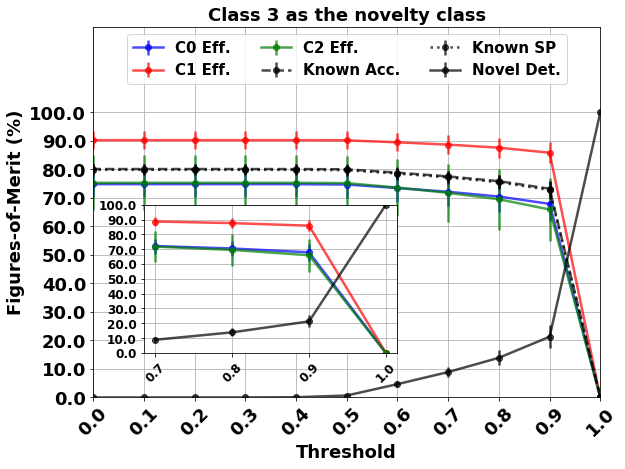

In [64]:
# analysis example - novelty detection for neural network
# thr. sweep

from sklearn import preprocessing
from Functions import TrainParameters as trnparams
from Functions import FunctionsDataVisualization

ineuron = 20

# generate analysis data
save_path=results_path

analysis_str = 'NeuralNetwork'
model_prefix_str = 'RawData'

current_analysis = 'figures_of_merit'

analysis_file_name='%s/%s/%s_%s_%i_neurons_novelty_detection_thr_sweep.jbl'%(results_path,analysis_str,
                                                                             analysis_name, 
                                                                             trn_params.get_params_str(),
                                                                             ineuron)

# if os.path.exists(analysis_file_name):
#         os.remove(analysis_file_name)

if not os.path.exists(analysis_file_name):
    trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
    
    if not os.path.exists(trn_params_folder):
        trn_params = trnparams.NNNoveltyDetectionTrnParams(n_epochs=30,n_inits=1)
        trn_params.save(trn_params_folder)
    else:
        trn_params = trnparams.NNNoveltyDetectionTrnParams()
        trn_params.load(trn_params_folder)

    params_str = trn_params.get_params_str()

    thr_mat = np.round(np.arange(-1.0,1.1,0.1),3)
    thr_mat[thr_mat>-0.1] = abs(thr_mat[thr_mat>-0.1])

    class_eff_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(np.unique(all_trgt)),len(thr_mat)])
    novelty_eff_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(thr_mat)])
    known_acc_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(thr_mat)])
    known_sp_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(thr_mat)])
    known_trig_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(thr_mat)])
    
    for inovelty, novelty_class in enumerate(np.unique(trgt)):
        trn_data = all_data[all_trgt!=novelty_class]
        trn_trgt = all_trgt[all_trgt!=novelty_class]
        # trgt max = 2
        trn_trgt[trn_trgt>novelty_class] = trn_trgt[trn_trgt>novelty_class]-1
        
        for ifold in range(len(CVO[inovelty])):
            print 'Novelty class: %01.0f - neuron: %i - fold %i'%(novelty_class, ineuron, ifold)
            [classifier,trn_desc] = TrainFunctions.NNNoveltyTrainFunction(data=trn_data,
                                                                          trgt=trn_trgt, 
                                                                          inovelty=inovelty, 
                                                                          ifold=ifold, 
                                                                          n_folds=len(CVO[inovelty]), 
                                                                          n_neurons=ineuron, 
                                                                          trn_params=trn_params, 
                                                                          save_path=results_path, 
                                                                          dev=development_flag)
            
            output = classifier.predict(trn_data)
            novelty_output = classifier.predict(all_data[all_trgt==novelty_class])
            for ithr,thr_value in enumerate(thr_mat): 
                buff = np.zeros([len(np.unique(trgt))-1])
                for iclass, class_id in enumerate(np.unique(trgt)):
                    if iclass == inovelty:
                        continue
                    output_of_class_events = output[trn_trgt==iclass-(iclass>inovelty),:]
                    correct_class_output = np.argmax(output_of_class_events,axis=1)==iclass-(iclass>inovelty)
                    output_above_thr = output_of_class_events[correct_class_output,iclass-(iclass>inovelty)]>thr_value
                    class_eff_mat[ifold, inovelty, iclass, ithr] = float(sum(output_above_thr))/float(len(output_of_class_events))
                    buff[iclass-(iclass>inovelty)] = class_eff_mat[ifold, inovelty, iclass, ithr]
                novelty_eff_mat[ifold, inovelty, ithr] = float(sum(1-(novelty_output>thr_value).any(axis=1)))/float(len(novelty_output))
                known_acc_mat[ifold, inovelty, ithr] = np.mean(buff,axis=0)
                known_sp_mat[ifold, inovelty, ithr]= (np.sqrt(np.mean(buff,axis=0)
                                                              *np.power(np.prod(buff),1./float(len(buff)))))
                known_trig_mat[ifold, inovelty, ithr]=float(sum(np.max(output,axis=1)>thr_value))/float(len(output))
    joblib.dump([class_eff_mat, novelty_eff_mat, known_acc_mat, known_sp_mat, known_trig_mat, thr_mat],
                analysis_file_name,compress=9)
else:
    print 'file exists'
    [class_eff_mat, novelty_eff_mat, known_acc_mat, known_sp_mat, known_trig_mat, thr_mat] = joblib.load(analysis_file_name) 

# plot analysis
import matplotlib.pyplot as plt
%matplotlib inline  

fig = plt.subplots(figsize=(20,15))

plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.numpoints'] = 1
plt.rc('legend',**{'fontsize':15})
plt.rc('font', weight='bold')

m_colors = ['b', 'r', 'g', 'y']

inovelty = 3

ax = plt.subplot(2,2,inovelty+1)
for iclass, m_class in enumerate(np.unique(all_trgt)):
    novelty_class = inovelty
    if novelty_class == m_class:
        #a = 0
        ax.errorbar(thr_mat,np.mean(novelty_eff_mat[:,int(novelty_class),:],axis=0),
                    np.std(novelty_eff_mat[:,int(novelty_class),:],axis=0),fmt='o-',
                    color='k',alpha=0.7,linewidth=2.5,
                    label='Novel Det.')
        ax.errorbar(thr_mat,np.mean(known_acc_mat[:,int(novelty_class),:],axis=0),
                    np.std(known_acc_mat[:,int(novelty_class),:],axis=0),fmt='o--',
                    color='k',alpha=0.7,linewidth=2.5,
                    label='Known Acc.')
        ax.errorbar(thr_mat,np.mean(known_sp_mat[:,int(novelty_class),:],axis=0),
                    np.std(known_sp_mat[:,int(novelty_class),:],axis=0),fmt='o:',
                    color='k',alpha=0.7,linewidth=2.5,
                    label='Known SP')
    else:
        ax.errorbar(thr_mat,np.mean(class_eff_mat[:,int(novelty_class),int(m_class),:],axis=0),
                    np.std(class_eff_mat[:,int(novelty_class),int(m_class),:],axis=0),fmt='o-',
                    color=m_colors[int(m_class)],alpha=0.7,linewidth=2.5,
                   label='C%i Eff.'%(int(iclass)))
ax.set_xticks(thr_mat)
ax.set_xticklabels(thr_mat,rotation=45, fontsize=18)
ax.set_title('Class %i as the novelty class'%inovelty,fontsize=18,weight='bold')
ax.set_xlim([0, np.max(thr_mat)])

ax.set_ylim([0.0, 1.3])
y_ticks = np.arange(0.0,1.1,0.1)
y_ticks = np.round(y_ticks,2)
ax.set_yticks(y_ticks)
ax.set_yticklabels(100*y_ticks[y_ticks<=1.0],fontsize=18)

ax.grid()

ax.set_xlabel('Threshold',fontsize=18,weight='bold')
ax.set_ylabel('Figures-of-Merit (%)',fontsize=18,weight='bold')

handles, labels = ax.get_legend_handles_labels()
# sort both labels and handles by labels
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
ax.legend(handles, labels, ncol=3, loc='upper center')
rect = [0.1, 0.12, 0.5, 0.4]
ax1 = FunctionsDataVisualization.add_subplot_axes(ax,rect)
a = thr_mat>=0.7 
b = thr_mat<=1
selected_thr = a & b
for iclass, m_class in enumerate(np.unique(all_trgt)):
    novelty_class = inovelty
    if novelty_class == m_class:
        #a = 0
        ax1.errorbar(thr_mat[selected_thr],np.mean(novelty_eff_mat[:,int(novelty_class),selected_thr],axis=0),
                    np.std(novelty_eff_mat[:,int(novelty_class),selected_thr],axis=0),fmt='o-',
                    color='k',alpha=0.7,linewidth=2.5,
                    label='Novel Det.')
    else:
        ax1.errorbar(thr_mat[selected_thr],np.mean(class_eff_mat[:,int(novelty_class),int(m_class),selected_thr],axis=0),
                    np.std(class_eff_mat[:,int(novelty_class),int(m_class),selected_thr],axis=0),fmt='o-',
                    color=m_colors[int(m_class)],alpha=0.7,linewidth=2.5,
                   label='C%i Eff.'%(int(m_class)+1))
ax1.set_xticks(thr_mat[selected_thr])
ax1.set_xticklabels(thr_mat[selected_thr],rotation=45, fontsize=12)

ax1.set_ylim([0.0, 0.9])
y_ticks = np.arange(0.0,1.1,0.1)
y_ticks = np.round(y_ticks,2)
ax1.set_yticks(y_ticks)
ax1.set_yticklabels(100.*ax1.get_yticks(), fontsize=12)

ax1.grid()
#Save the figure
file_name = pict_results_path+'/'+current_analysis+'_%i_novelty_%s_neurons_'%(inovelty,ineuron)+trn_params.get_params_str()+'.pdf'
plt.savefig(file_name)


print trn_params.get_params_str()